In [8]:
#| include: false
library(tidyverse)
library(readxl)

Warning message:
"package 'readxl' was built under R version 4.1.3"


# Results

## Transmission distortion is common

In [34]:
# load the manual overview of the crosses in Excel format
Crosses_xlsx<-read_xlsx("~/data/trd/Crosses.xlsx", sheet=2) # should be moved to the github
mean_colonies<-summarize(Crosses_xlsx, mean(`Colonies in pool`, na.rm=TRUE))%>%pull()
sd_colonies<-summarize(Crosses_xlsx, sd(`Colonies in pool`, na.rm=TRUE))%>%pull()

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


In [45]:
# Load table with summarizes stats for all TRD regions
One_Table<-read_csv("03_GenomicSignals/03_OneTable.csv.gz")
One_Table<-filter(One_Table, !is.na(AF))

Rows: 168 Columns: 60
-- Column specification ----------------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (2): chr, cross
dbl (57): ID, lengthSNPs, global_start, global_end, lengthBp, start, end, PC...
lgl  (1): strongest

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [46]:
# How common is TRD?
nCrossesWithTRD<-summarize(One_Table, nCrosses=length(unique(cross)))%>%pull()

# Strength of TRD
# why NAs?
AF_summary<-summarize(One_Table, meanAF=mean(abs(AF-0.5)+0.5, na.rm=TRUE),
                     sdAF=sd(abs(AF-0.5)+0.5, na.rm=TRUE))

In [51]:
# How many TRD per cross?
TRD_summary<-group_by(One_Table, cross)%>%summarize(n=n(), nUp=sum(AF>0.5), OnlyOneDirection=nUp==n)%>%
summarize(meanN=mean(n), sdN=sd(n), OnlyOneDirection=sum(OnlyOneDirection)/n())
TRD_summary

meanN,sdN,OnlyOneDirection
<dbl>,<dbl>,<dbl>
3.6875,5.578978,0.34375


In [55]:
#| output: asis
#| echo: false
cat("We conducted 34 crosses, of which 30 were succesful, with on average",round(mean_colonies),"$\\pm$",round(sd_colonies), "(SD) colonies retreived per cross.")
cat("Combined with an additional 8 crosses from a preliminary study, we find that out of 38 crosses,",nCrossesWithTRD,"or",round(nCrossesWithTRD/38*100),"% show regions under TRD.")
cat("On average, transmissions were distorted to allele frequencies of",paste0(round(100*pull(AF_summary, meanAF)),"%"),"$\\pm$",paste0(round(100*pull(AF_summary, sdAF))),"as opposed to the expected 50%. ")
cat("Crosses with TRD, had on average",round(pull(TRD_summary, meanN),2),"$\\pm$",round(pull(TRD_summary, sdN),2),"regions under distortion.",
   round(pull(TRD_summary, OnlyOneDirection)*100,2),"% of crosses with TRD only had distortion in one direction.")

We conducted 34 crosses, of which 30 were succesful, with on average 1419 $\pm$ 736 (SD) colonies retreived per cross.Combined with an additional 8 crosses from a preliminary study, we find that out of 38 crosses, 32 or 84 % show regions under TRD.On average, transmissions were distorted to allele frequencies of 70% $\pm$ 11 as opposed to the expected 50%. Crosses with TRD, had on average 3.69 $\pm$ 5.58 regions under distortion. 34.38 % of crosses with TRD only had distortion in one direction.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 4 rows containing non-finite values (`stat_bin()`)."


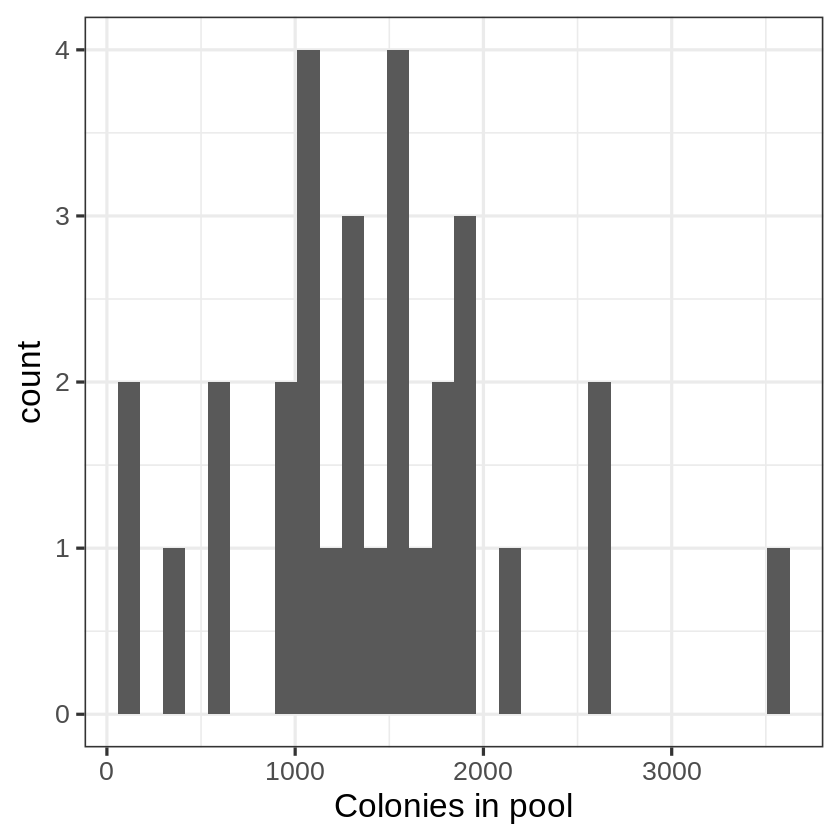

In [19]:
#| label: fig-colonies
#| fig-cap: Distribution of the number of colonies that were retrieved per cross

ggplot(Crosses_xlsx, aes(`Colonies in pool`))+
geom_histogram()+theme_bw(20)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 50 rows containing non-finite values (`stat_bin()`)."


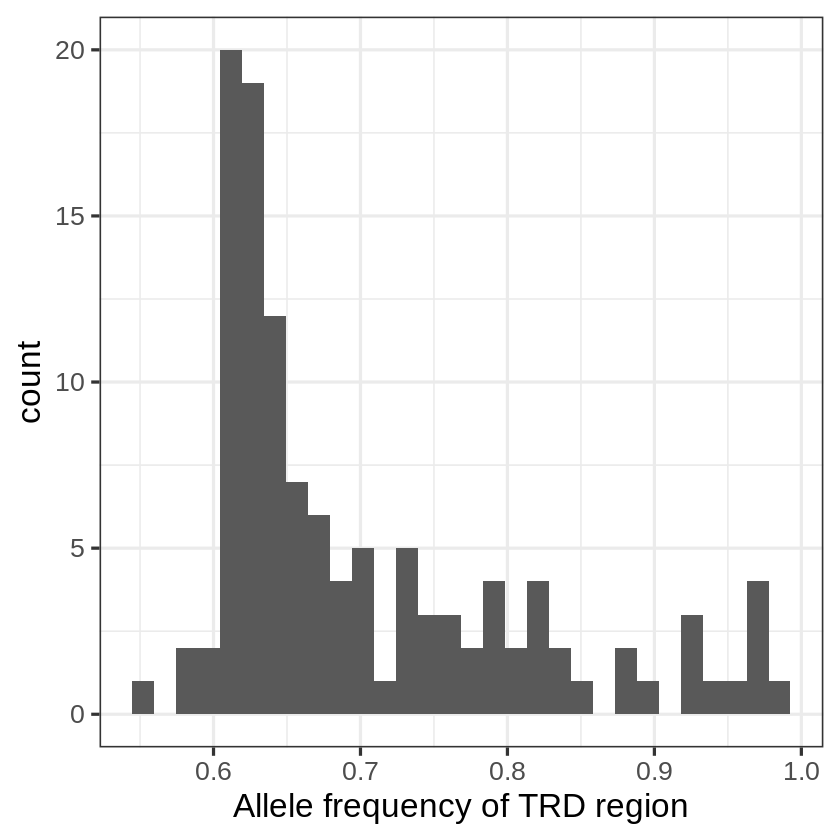

In [42]:
#| label: fig-AF
#| fig-cap: Distribution of allele frequencies of those regions classified as under distortion

ggplot(One_Table, aes(abs(AF-0.5)+0.5))+
geom_histogram()+theme_bw(20)+xlab("Allele frequency of TRD region")

## Distorted regions show signals of selection


In [78]:
#| label: tbl-signals-distributions
#| tbl-cap: TBD

One_Table_sd_based_values<-One_Table%>%select(matches("sd|standardized"))%>%select(!matches("multiplier_[12]"))%>%
select(-LD_sd_multi_2)%>%
rename(`IBS, d`=IBS_eucldist_sd_multiplier_distorter,
      `IBS, o`=IBS_eucldist_sd_multiplier_other,
      `LD`=LD_sd_multi_1,
       `PCA, d`=PCA_eucldist_sd_multiplier_distorter,
       `PCA, o`=PCA_eucldist_sd_multiplier_other,
       `TD`=TD_sd_multi,
       `Dxy`=standardized_measure_dxy,
       `Fst`=standardized_measure_fst,
       `Pi, d`=standardized_measure_pi_distorter,
       `Pi, o`=standardized_measure_pi_other,
       `Phylo`=tree_changes_sd_multiplier)%>%
pivot_longer(cols=everything())%>%filter(!is.na(value))

One_Table_sd_based_values_means<-One_Table_sd_based_values%>%group_by(name)%>%summarize(mean=mean(value),
                                                                                       ttest_p_value=t.test(value,
                                                                                                           mu=0)$p.value)

One_Table_sd_based_values_means%>%rename(Signal=name, `Mean value (x SD)`=mean, `p (t test vs 0)`=ttest_p_value)

Signal,Mean value (x SD),p (t test vs 0)
<chr>,<dbl>,<dbl>
Dxy,-0.03144709,1.280569e-02
Fst,1.27227550,4.489771e-02
"IBS, d",0.26708263,8.621690e-03
"IBS, o",0.21568756,4.442233e-02
LD,2.59480243,3.887725e-50
"PCA, d",0.09788984,3.298542e-01
"PCA, o",0.10943295,2.338557e-01
Phylo,-10.67188584,4.167297e-117
"Pi, d",-0.08047421,1.738236e-11


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


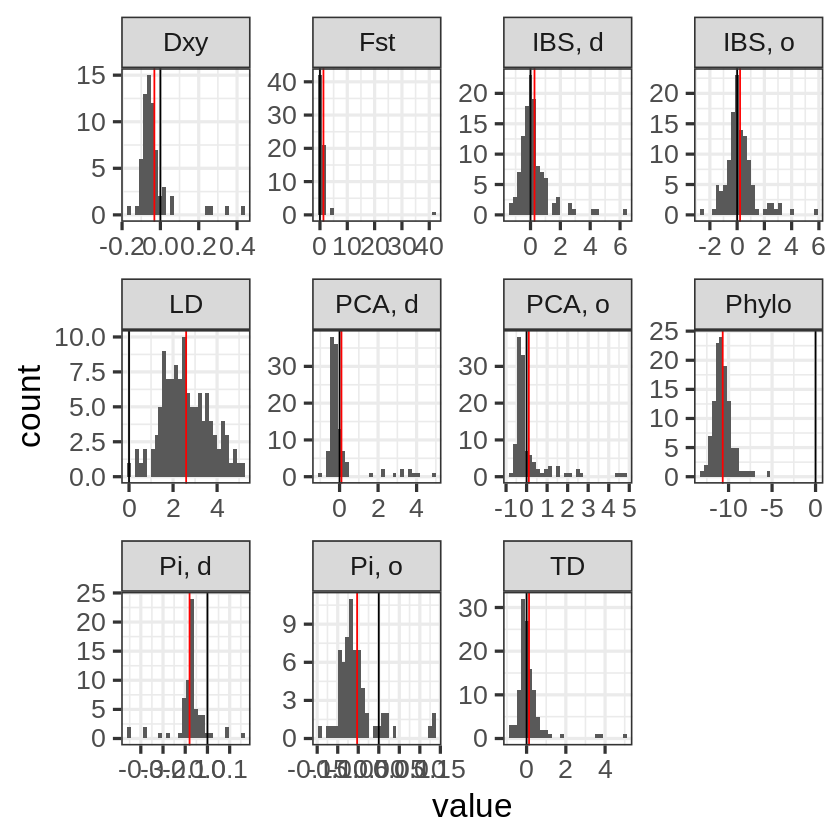

In [86]:
#| label: fig-signals-distributions
#| fig-cap: Distribution of genomic signals at TRD regions. All values are compared to the averages across the genome and given in SD distance to the mean, i.e. a value of 1 indicates that the respective TRD region has a one SD greater value than the average genome-wide. IBS distance from other strains, distorter; IBS distance from other strains; LD TRD region species-wide; PCA distance from other strains, distorter; PCA distance from other strains, other; Tajima's D TRD region species-wide; Dxy distorter-like vs all other strains; Fst distorter-like vs all other strains; Pi within distorter-like strains; Pi within other strains`=standardized_measure_pi_other; Distance TRD locus phylogeny to genome-wide (broken)


ggplot(One_Table_sd_based_values,
      aes(value))+
geom_histogram()+facet_wrap(~name, scales="free")+geom_vline(xintercept=0)+
geom_vline(data=One_Table_sd_based_values_means, aes(xintercept=mean), color="red")+
theme_bw(20)


In [102]:
#| output: asis
#| echo: false
cat("The most noteworthy genomic signals that were associated with TRD regions were nucleotide diversity, F_\\text{st}, linkage disequilibrium, and the placement among other strains. ")
cat("We detected a statistically significant, but small, decrease in nucleotide diversity, in distorter-like strains by",filter(One_Table_sd_based_values_means, name=="Pi, d")%>%pull(mean)%>%round(2),"\\sigma and in other strains by",filter(One_Table_sd_based_values_means, name=="Pi, o")%>%pull(mean)%>%round(2),"\\sigma. F_\\text{st} was strongly increased, even more so in an outlier up to",One_Table_sd_based_values%>%group_by(name)%>%summarize(max=max(value))%>%filter(name=="Fst")%>%pull(max)%>%round(2),"\\sigma", "but on average",filter(One_Table_sd_based_values_means, name=="Fst")%>%pull(mean)%>%round(2),"\\sigma.")
cat("Linkage disequillibrium has a bimodal shape across the genome. Compared to the lower mode, TRD regions were shifted upwards by",filter(One_Table_sd_based_values_means, name=="LD")%>%pull(mean)%>%round(2),"\\sigma.")
cat("Finally, we compared how unique the TRD region is by creating an MDS plot based on IBS distances in the TRD region among all strains, and measuring the distance to the null point in both distorter and distorted strain. We compared these distances to the distances in random regions across the genome. We found that TRD regions were more distant to the average strain in distorter (",
   filter(One_Table_sd_based_values_means, name=="IBS, d")%>%pull(mean)%>%round(2),"\\sigma) and distorted (",
    filter(One_Table_sd_based_values_means, name=="IBS, o")%>%pull(mean)%>%round(2),"\\sigma)")

The most noteworthy genomic signals that were associated with TRD regions were nucleotide diversity, F_\text{st}, linkage disequilibrium, and the placement among other strains. We detected a statistically significant, but small, decrease in nucleotide diversity, in distorter-like strains by -0.08 \sigma and in other strains by -0.05 \sigma. F_\text{st} was strongly increased, even more so in an outlier up to 41.14 \sigma but on average 1.27 \sigma.Linkage disequillibrium has a bimodal shape across the genome. Compared to the lower mode, TRD regions were shifted upwards by 2.59 \sigma.Finally, we compared how unique the TRD region is by creating an MDS plot based on IBS distances in the TRD region among all strains, and measuring the distance to the null point in both distorter and distorted strain. We compared these distances to the distances in random regions across the genome. We found that TRD regions were more distant to the average strain in distorter ( 0.27 \sigma) and distorted 

## No particular genomic signals sub-structure among TRD regions

Given the great diversity among signals, we aimed to classify TRD regions according to the signals associated with them. To that end, we constructed a PCA of the genomic signals and visualized the placement of strains. We visually inferred that among the first 6 dimensions, no substructure was evident, i.e. there was only one cluster of strains. However, the first dimension did show a few outliers that we look at in more detail.

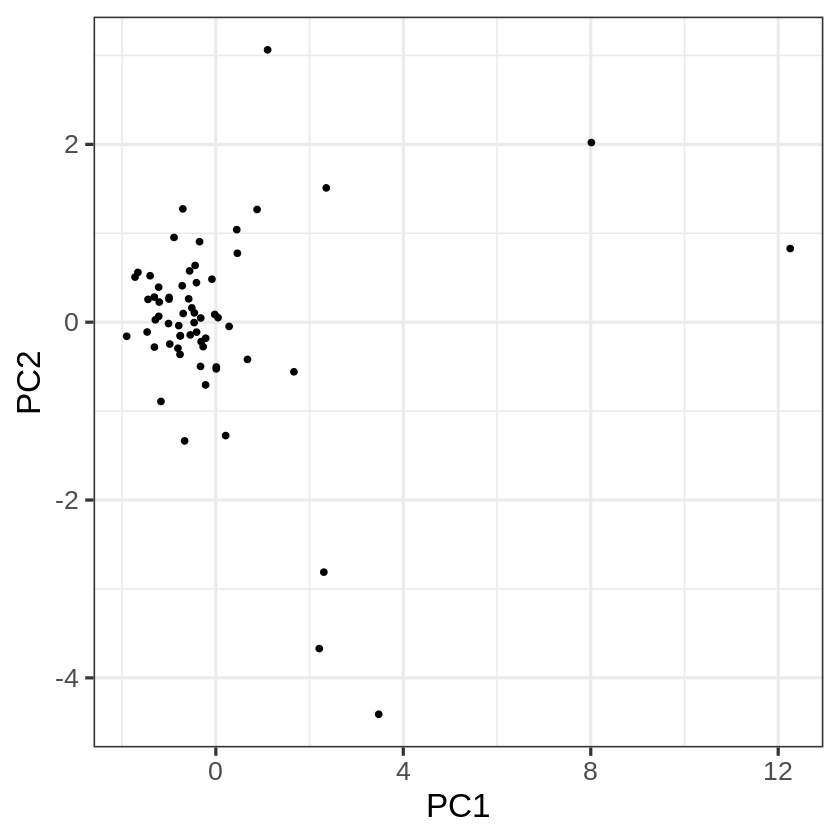

In [107]:
#| label: fig-pca
#| fig-cap: First two dimension of a PCA of all genomic signals seen in @tbl-signals-distributions.

pca_df<-readRDS("~/data/trd/genomic_signals_pca.RDS")
ggplot(pca_df,
      aes(PC1,PC2))+
geom_point()+theme_bw(20)+scale_color_viridis_d()+theme(legend.position="none")

## Almost no association with structural variants


## Enrichment for genes with ...

In [ ]:
library(rrvgo)
reducedTerms<-readRDS("03_GenomicSignals/overall_reducedTerms.RDS")
treemapPlot(reducedTerms)
wordcloudPlot(reducedTerms, min.freq=1, colors="black")

## Standout TRD regions



### Outliers in the PCA

In [113]:
filter(pca_df, PC1>2|PC2< -2|PC2>2)%>%select(cross, ID)

cross,ID
<chr>,<dbl>
ChrisC8,2
YJNRC18,1
YJNRC3,2
YJNRC3,4
YJNRC4,12
YJNRC4,25
YJNRC5,1


### The most extreme distorters

In [110]:
select(One_Table, cross, ID, AF)%>%arrange(-AF)%>%head(30)

cross,ID,AF
<chr>,<dbl>,<dbl>
YJNRC4,11,0.9786811
YJNRC9,64,0.9744900
YJNRC4,12,0.9737680
YJNRC4,10,0.9676556
YJNRC4,24,0.9642343
YJNRC4,9,0.9589128
YJNRC4,3,0.9424768
YJNRC4,36,0.9260778
YJNRC4,8,0.9253091
